In [1]:
from __future__ import print_function
%tensorflow_version 1.x
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
import cv2
from scipy.optimize import fmin_l_bfgs_b
import imageio
import urllib

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
!wget https://res.cloudinary.com/occsn/image/upload/v1590208488/products/VanGoghStarryNight_rzbnwt.jpg
!wget https://a.1stdibscdn.com/nancy-eckels-paintings-cool-motion-by-nancy-eckels-large-abstract-painting-with-textural-blue-greens-for-sale/archivesE/upload/a_8421/a_26938611522615469928/Cool_Motion_for_PEG_master.jpg

--2021-07-08 03:26:43--  https://res.cloudinary.com/occsn/image/upload/v1590208488/products/VanGoghStarryNight_rzbnwt.jpg
Resolving res.cloudinary.com (res.cloudinary.com)... 151.101.1.137, 151.101.65.137, 151.101.129.137, ...
Connecting to res.cloudinary.com (res.cloudinary.com)|151.101.1.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240057 (234K) [image/jpeg]
Saving to: ‘VanGoghStarryNight_rzbnwt.jpg’

VanGoghStarryNight_ 100%[===================>] 234.43K  --.-KB/s    in 0.1s    

2021-07-08 03:26:43 (1.76 MB/s) - ‘VanGoghStarryNight_rzbnwt.jpg’ saved [240057/240057]

--2021-07-08 03:26:43--  https://a.1stdibscdn.com/nancy-eckels-paintings-cool-motion-by-nancy-eckels-large-abstract-painting-with-textural-blue-greens-for-sale/archivesE/upload/a_8421/a_26938611522615469928/Cool_Motion_for_PEG_master.jpg
Resolving a.1stdibscdn.com (a.1stdibscdn.com)... 151.101.1.205, 151.101.65.205, 151.101.129.205, ...
Connecting to a.1stdibscdn.com (a.1stdibscdn.com)|1

In [3]:
!wget https://img.artpal.com/490131/31-19-9-26-12-20-41m.jpg

--2021-07-08 03:26:45--  https://img.artpal.com/490131/31-19-9-26-12-20-41m.jpg
Resolving img.artpal.com (img.artpal.com)... 52.84.169.100, 52.84.169.113, 52.84.169.67, ...
Connecting to img.artpal.com (img.artpal.com)|52.84.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91857 (90K) [image/jpeg]
Saving to: ‘31-19-9-26-12-20-41m.jpg’

31-19-9-26-12-20-41 100%[===================>]  89.70K   437KB/s    in 0.2s    

2021-07-08 03:26:45 (437 KB/s) - ‘31-19-9-26-12-20-41m.jpg’ saved [91857/91857]



In [5]:
!wget https://lp-cms-production.imgix.net/features/2014/10/14250876721_0f11a65f3d_o.jpg?auto=compress&fit=crop&fm=auto&sharp=10&vib=20&w=1200&h=800

--2021-07-08 03:28:00--  https://lp-cms-production.imgix.net/features/2014/10/14250876721_0f11a65f3d_o.jpg?auto=compress
Resolving lp-cms-production.imgix.net (lp-cms-production.imgix.net)... 151.101.54.208, 2a04:4e42:d::720
Connecting to lp-cms-production.imgix.net (lp-cms-production.imgix.net)|151.101.54.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66228 (65K) [image/jpeg]
Saving to: ‘14250876721_0f11a65f3d_o.jpg?auto=compress’

14250876721_0f11a65 100%[===================>]  64.68K  --.-KB/s    in 0.008s  

2021-07-08 03:28:00 (7.91 MB/s) - ‘14250876721_0f11a65f3d_o.jpg?auto=compress’ saved [66228/66228]



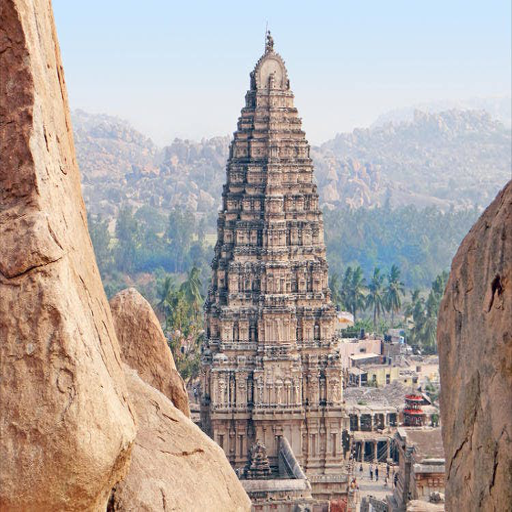

In [6]:
height = 512
width = 512

content_image_path = '/content/14250876721_0f11a65f3d_o.jpg?auto=compress'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

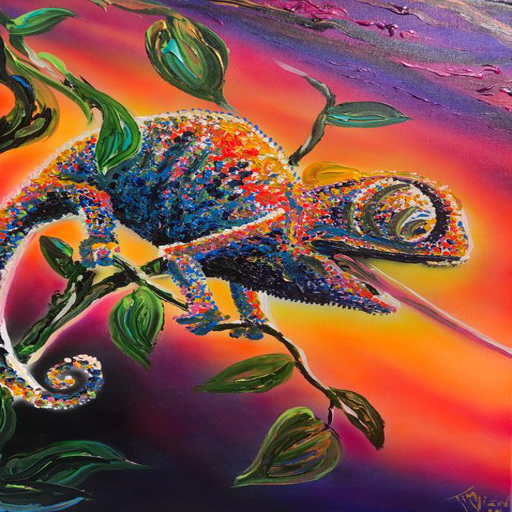

In [7]:
style_image_path = '/content/31-19-9-26-12-20-41m.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))

style_image

In [8]:
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)


print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [9]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [10]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:

input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [12]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)


58892288/58889256 [==============================] - 1s 0us/step


In [13]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [14]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [15]:
loss = backend.variable(0.)

In [16]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

In [17]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [18]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [19]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss = loss + total_variation_weight * total_variation_loss(combination_image)


In [20]:
grads = backend.gradients(loss, combination_image)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [22]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 20

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 114619286000.0
Iteration 0 completed in 16s
Start of iteration 1
Current loss value: 55590613000.0
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 37180903000.0
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 29930910000.0
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 26631447000.0
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 25264929000.0
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 24241443000.0
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 23710750000.0
Iteration 7 completed in 6s
Start of iteration 8
Current loss value: 23382563000.0
Iteration 8 completed in 6s
Start of iteration 9
Current loss value: 23175434000.0
Iteration 9 completed in 6s
Start of iteration 10
Current loss value: 23038722000.0
Iteration 10 completed in 6s
Start of iteration 11
Current loss value: 22939257000.0
Iteration 11 completed in 6

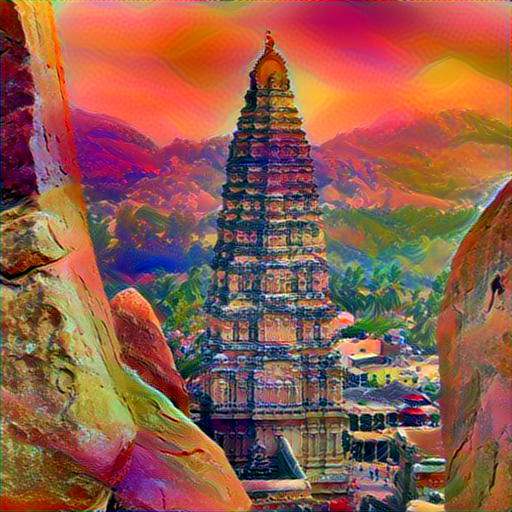

In [23]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)